# Train

In [0]:
import pandas as pd
import numpy as np
import math
import os
import random
import argparse
import csv
import cv2
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.autograd import Variable
import torch.utils.data as data_utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, AvgPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets


# Problem 3 - Training a small CNN
#Parameters
cuda_enabled = True
batch_size = 5000

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, dev_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
dev_sampler = SubsetRandomSampler(dev_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)
dev_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=dev_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# print one batch of training images
# dataiter = iter(train_loader)
# images, labels = dataiter.next()
# images = images.numpy() # convert images to numpy for display

# for i in np.arange(len(images)):
#     img = images[i] / 2 + 0.5  # unnormalize
#     img = np.transpose(img, (1, 2, 0))
#     plt.imshow(img)
#     plt.title(classes[labels[i]])
#     plt.show()


# define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(kernel_size=3)
        self.fc = nn.Linear(128*4*4, 10)
        self.softmax = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        #print('x',x.shape)
        x = self.conv1(x)
        #print('conv1',x.shape)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        #print('maxpool',x.shape)  
        x = self.conv2(x)
        #print('conv2',x.shape)
        x = self.batch_norm2(x)
        x = self.conv3(x)
        #print('conv3',x.shape)
        x = self.batch_norm3(x)
        x = self.relu(x)
        #print('relu',x.shape)
        x = self.avgpool(x)
        #print('avgpool',x.shape)

        # flattening
        x = x.view(-1, 128 * 4 * 4)
        #print('x.view',x.shape)

        # fully connected layers
        x = self.fc(x)
        #print('fc',x.shape)
        x = self.softmax(x)
        #print('softmax',x.shape)
        return x
    

model = CNN()
loss_function = nn.CrossEntropyLoss()

if cuda_enabled:
    model = model.cuda()
    loss_function = loss_function.cuda()

print(model)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0) 
epochs = 100

loss_history_train = []
loss_history_dev = []

for i in range(epochs):
    loss_total_train = 0
    loss_total_dev = 0

    #Train set
    model.train()
    j = 0
    for input, target in train_loader:
        print('epoch',i,'train batch',j)
        if cuda_enabled:
            input, target = input.cuda(), target.cuda()
        # Forward Propagation
        output = model(input)
        # Compute and print loss
        loss_train = loss_function(output, target)
        loss_total_train += loss_train.item()
        # Zero the gradients
        optimizer.zero_grad()   
        # perform a backward pass (backpropagation)
        loss_train.backward()
        # Update the parameters
        optimizer.step()
        j +=1
        
    lose_avg_train = float(loss_total_train)/j 
    loss_history_train.append(lose_avg_train)

    #Dev set
    model.eval()
    j = 0
    for input, target in dev_loader:
        print('epoch',i,'dev batch',j)
        if cuda_enabled:
            input, target = input.cuda(), target.cuda()
        # Forward Propagation
        output = model(input)
        # Compute and print loss
        loss_dev = loss_function(output, target)
        loss_total_dev += loss_dev.item()
        j +=1
        
    lose_avg_dev = float(loss_total_dev)/j 
    loss_history_dev.append(lose_avg_dev)

    print('epoch:',i,'loss train:', lose_avg_train, 'loss dev:', lose_avg_dev)



Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
CNN(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (avgpool): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)
epoch 0 train batch 0
epoch 0 train batch 1
epoch 0 train batch 2
epoch 0 train batch 3
epoch 0 train batch 4
epoch

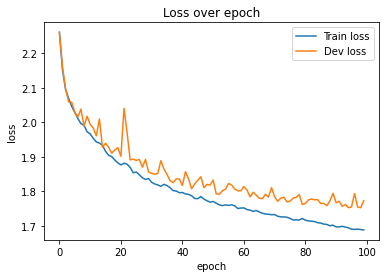

In [0]:
#Plot loss
plt.figure(1)
plt.plot(range(len(loss_history_train)),loss_history_train)
plt.plot(range(len(loss_history_dev)),loss_history_dev)
plt.title('Loss over epoch')
plt.legend(['Train loss','Dev loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#Test



In [0]:
#Test set
loss_history_test = []
loss_total_test = 0
class_correct = np.zeros(len(classes))
class_total = np.zeros(len(classes))

model.eval()
j = 0
for input, target in test_loader:
    print('test batch',j)
    if cuda_enabled:
        input, target = input.cuda(), target.cuda()
    # Forward Propagation
    output = model(input)
    # Compute and print loss
    loss_test = loss_function(output, target)
    loss_total_test += loss_test.item()
    # convert output probabilities to predicted class
    _, prediction = torch.max(output,1)
    # compare predictions to true label
    correct_tensor = prediction.eq(target.data.view_as(prediction))
    correct = np.squeeze(correct_tensor.numpy()) if not cuda_enabled else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for k in range(batch_size):
        label = target.data[k]
        class_correct[label] += correct[k].item()
        class_total[label] += 1
    j +=1
    
# Test loss
lose_avg_test = float(loss_total_test)/j 
loss_history_test.append(lose_avg_test)
print('loss test:', lose_avg_test)

# Accuracy of each class
for i in range(10):
    print('Test Accuracy of', classes[i],':', 
          100 * class_correct[i] / class_total[i],'%',
          '(',np.sum(class_correct[i]), '/',
          np.sum(class_total[i]),')')

print('\nTest Accuracy (Overall):',  
    100 * np.sum(class_correct) / np.sum(class_total),'%',
    '(', np.sum(class_correct), '/',
    np.sum(class_total),')')

test batch 0
test batch 1
loss test: 1.7765164971351624
Test Accuracy of airplane : 71.7 % ( 717.0 / 1000.0 )
Test Accuracy of automobile : 79.3 % ( 793.0 / 1000.0 )
Test Accuracy of bird : 58.8 % ( 588.0 / 1000.0 )
Test Accuracy of cat : 51.0 % ( 510.0 / 1000.0 )
Test Accuracy of deer : 62.9 % ( 629.0 / 1000.0 )
Test Accuracy of dog : 63.6 % ( 636.0 / 1000.0 )
Test Accuracy of frog : 67.9 % ( 679.0 / 1000.0 )
Test Accuracy of horse : 74.2 % ( 742.0 / 1000.0 )
Test Accuracy of ship : 86.7 % ( 867.0 / 1000.0 )
Test Accuracy of truck : 77.4 % ( 774.0 / 1000.0 )

Test Accuracy (Overall): 69.35 % ( 6935.0 / 10000.0 )
